In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder 
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
import csv


class case1TrainSet:
    #class for reading and transforming training data for case 1
    def __init__(self,path=None):
        if(path == None):
            self.path = ""
        else:
            self.path = path
        self.initialize_data()

    def initialize_data(self):
        #called on initialization. Reads dataframe, splits data into numeric values Y, X1:X95, C1:C5 (denoted X_c). 
            #Transformation steps:
                #Standardizes X1:X95. shape (100,95)
                #one-hot encodes categorical variables. Thus, categorical variables are transformed from shape (100,5) to (100,21) when excluding C2
                #thus field X holds (100,116) array
        
        #read I/O
        self.orig_data = self.read_df()
        self.var_names = self.read_var_names()
        #split into numeric/categoric
        self.Y, self.X_orig, self.X_c_orig = self.split_data()
        self.convertNumeric()
        #data transforms
        self.X_numeric = self.standardize_df()
        self.onehot_encoder = None
        self.X_c = self.oneHotEncode(removeC2=True)
        self.X = self.merge_data()
        self.N_columns = self.X.shape[1]
        self.N_obs = self.X.shape[0]
        self.N_numeric = self.X_numeric.shape[1]
        self.N_categorical = self.X_c.shape[1]

    ###I/O functions
    def read_df(self):
        df = pd.read_table(self.path+"case1Data.txt", delimiter=",")
        return df

    def read_var_names(self):
        with open(self.path+'var_names.txt', newline='') as f:
            reader = csv.reader(f)
            var_names = list(reader)
        var_names = var_names[0]
        names = [x.replace(" ","").replace("_","") for x in var_names]
        return names 


    ###Data formatting functions
    def split_data(self):
        dfY = self.orig_data.iloc[:,0]
        dfX = self.orig_data.iloc[:, 1:96]
        dfX_c = self.orig_data.iloc[:, 96:]
        return dfY, dfX, dfX_c 
    
    def merge_data(self):
        ###concatenates the dataset. Note output is a np-array
        fullData = np.concatenate((self.X_numeric,self.X_c),axis=1)
        return fullData

    def convertNumeric(self):
        #fix it so NaNs are not strings but rather np.NaN
        for col in self.X_orig.columns:
            self.X_orig[col]=pd.to_numeric(self.X_orig[col], errors="coerce")
        self.Y = pd.to_numeric(self.Y,errors="coerce").to_numpy()
        return

    ###Data transforms 
    def standardize_col(self,column):
        return (column - column.mean()) / column.std()

    def standardize_df(self):
        scaler = StandardScaler() 
        standardizedData = scaler.fit_transform(self.X_orig) 
        return standardizedData
    
    def oneHotEncode(self,removeC2=True):
        if(self.onehot_encoder==None):
            self.onehot_encoder = OneHotEncoder()
        df_cat_np = self.X_c_orig.to_numpy()
        if(removeC2):
            df_cat_np = np.concatenate((df_cat_np[:,0,None],df_cat_np[:,2:]),axis=1) #remove C_2 as it is not informative except possibly NaN? 
            self.var_names.remove("C2")
        self.onehot_encoder.fit(df_cat_np)
        categorical_onehot = self.onehot_encoder.transform(df_cat_np).toarray()
        return categorical_onehot
    
    ###Data imputation schemes
    def simple_imputation(self,imputationStrategy="mean"):
        self.saveMissingIndices()
        #strategies: "mean","median", "most frequent"
        self.imputer = SimpleImputer(missing_values=np.nan, strategy=imputationStrategy)
        self.X = self.imputer.fit_transform(self.X)
        self.imputer_name = f"{imputationStrategy} univariate imputation"
        return 
    
    def KNN_imputation(self,n_neighbours=5,weights="uniform"):
        #https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer
        #possible weight schemes: "uniform" (Equal influence of K nearest points),"distance" (Closer points in neighbourhood larger influence)
        self.saveMissingIndices()
        self.imputer = KNNImputer(n_neighbors=n_neighbours, weights=weights)
        self.X = self.imputer.fit_transform(self.X)
        self.imputer_name = f"KNN k={n_neighbours} W={weights}"
    
    
    def iterative_imputation(self,max_iter=10,random_state=1):
        self.saveMissingIndices()
        self.imputer = IterativeImputer(max_iter=max_iter, random_state=random_state,sample_posterior=False) #set sample_posterior true if using multiple imputations per sample 
        self.X = self.imputer.fit_transform(self.X)
        self.imputer_name = f"iterative k_max={max_iter}"
        
    def saveMissingIndices(self):
        #method which saves indices which were NaN before imputation in order to visualize quality of imputation in scatter-plots
        self.missing_mask = np.isnan(self.X)
        return
    

    def reset_values(self): 
        #destructor-restructor to re-initialize data without any transforms 
        self.__init__()
        return 
    


    



In [182]:
class case1Plotter(case1TrainSet):
    def __init__(self,dataset):
        self.data = dataset

    def scatterplots(self,pointsize=1.5,savefig=True):
        [n,p_numeric] = self.data.X_orig.shape
        fig, axs = plt.subplots(10,10,figsize=(16,18),sharey=True)
        pointsize=1.5

        X = self.data.X_orig.to_numpy()
        Y = self.data.Y

        labels = self.data.var_names.copy()
        try:
            labels.remove("C2") #remove C_2 from labels 
        except ValueError: #already removed by earlier in-place method 
            pass
        
        for p, ax in enumerate(axs.ravel()):
            #if(p>=p_numeric): #used all numeric data-frames, plot distribution of categorical excluding feature which only contains H
                #unique, counts = np.unique(df_cat_np[:,p-p_numeric],return_counts=True)
                #ax.bar(x=unique,height=counts)
            #    ax.scatter(x=df_cat_np[:,p-p_numeric],y=df_np[:,0],s=pointsize)
            #else:
            if(p>=p_numeric):
                break
            ax.scatter(x=X[:,p],y=Y,s=pointsize)
            ax.text(.15,.9,f'{labels[p]}',
                horizontalalignment='center',
                transform=ax.transAxes)
            #ax.set_yticks([])
            ax.set_xticks([])
        if(savefig):
            fig.savefig("scatterplots_no_impute.png")
        plt.show()
        return

    
    def scatterplots_imputed(self,title="imputed values",pointsize=1.5,savefig=True):
        fig, axs = plt.subplots(10,10,figsize=(16,18),sharey=True)
        pointsize=1.5
        labels = self.data.var_names.copy() 
        try:
            labels.remove("C2") #remove C_2 from labels 
        except ValueError: #already removed by earlier in-place method 
            pass
        
        for p, ax in enumerate(axs.ravel()):
            colors = ["tab:blue" if x==False else "red" for x in self.data.missing_mask[:,p]]
            ax.scatter(x=self.data.X[:,p],y=self.data.Y,s=pointsize,color=colors)
            ax.text(.15,.9,f'{labels[p]}',
                horizontalalignment='center',
                transform=ax.transAxes)
            #ax.set_yticks([])
            ax.set_xticks([])
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='Non-imputed',
            markerfacecolor='tab:blue', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Imputed',
            markerfacecolor='red', markersize=10)
        ]

        fig.legend(title=self.data.imputer_name, handles=legend_elements, loc='upper center', ncols=2,bbox_to_anchor=(0.5,0.92))
        if(savefig):
            fig.savefig(f"{self.data.imputer_name}.png")
        plt.show()
        return 
    
    def covariance_plot(self,title=None,covAnalysis=False,savefig=False):
        standardizedY = (self.data.Y-np.mean(self.data.Y))/np.std(self.data.Y)
        concat_data = np.concatenate((standardizedY[:,None],self.data.X),axis=1)
        covs = np.cov(concat_data,rowvar=False)
        print("covariance shape: ",covs.shape)
        print("covariances : ",covs)
        corrs = np.corrcoef(x=concat_data,rowvar=False)
        fig, ax = plt.subplots(2,1,figsize=(10,10))
        covIm = ax[0].imshow(covs,cmap="viridis")
        #plt.colorbar(covIm,ax=ax[0])
        ax[0].set_title("Imputed Covariance")
        plt.colorbar(covIm,fraction=0.046, pad=0.04)
        
        corrIm = ax[1].imshow(corrs,cmap="viridis")
        #cax = fig.add_axes([ax[1].get_position().x1-0.25,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
        #fig.colorbar(covIm, cax=cax)
        plt.colorbar(corrIm,fraction=0.046, pad=0.04)
        ax[1].set_title("Imputed Correlation")
        if(savefig):
            fig.savefig(f'{self.data.imputer_name}_cov_corr.png')
        plt.show()
        #if(covAnalysis):
            #printHighCorrelations(corrs)
        return 


    def plotDataDistribution(self,savefig=True):
        #def plot_distributions(numeric_data,categorical_data):
        [n,p_numeric] = self.data.X.shape
        fig, axs = plt.subplots(10,10,figsize=(16,18))
        labels = self.data.var_names.copy()
        try:
            labels.remove("C2") #remove C_2 from labels 
        except ValueError:
            pass
        for p, ax in enumerate(axs.ravel()):
            #if(p>=p_numeric): #used all numeric data-frames, plot distribution of categorical excluding feature which only contains H
            #    unique, counts = np.unique(df_cat_np[:,p-p_numeric],return_counts=True)
            #    ax.bar(x=unique,height=counts)
            if(p>=self.data.N_numeric):
                pass
            else:
                ax.hist(x=self.data.X[:,p],bins=20,density=True)
                
                ax.text(.15,.9,f'{labels[p]}',
                horizontalalignment='center',
                transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            
        
        if(savefig):
            fig.savefig("dataDistribution.png")
        plt.show()
        return None

    





Let's build imputation schemes and check that they do what we want them to

In [137]:
data = case1TrainSet()
print(data.X)

print(np.nanmean(data.X,axis=0)[0])
data.simple_imputation("mean")
print(data.X)
#data.reset_values()

[[        nan         nan  1.81224096 ...  0.          1.
   0.        ]
 [ 0.64001852 -0.13431886  0.47050056 ...  0.          0.
   0.        ]
 [-1.74338024 -0.06920669  0.11771697 ...  0.          0.
   0.        ]
 ...
 [ 0.93796032 -0.53859828 -0.36946085 ...  0.          1.
   0.        ]
 [-1.17270539 -0.52090251         nan ...  0.          0.
   0.        ]
 [-0.34008003 -1.79587601 -0.60008749 ...  1.          0.
   0.        ]]
-1.1049362483174177e-15
[[-1.10493625e-15  7.14626315e-17  1.81224096e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 6.40018520e-01 -1.34318863e-01  4.70500564e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.74338024e+00 -6.92066875e-02  1.17716965e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 9.37960319e-01 -5.38598275e-01 -3.69460849e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-1.17270539e+00 -5.20902510e-01 -3.67333050e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [

In [116]:
data.missing_mask

array([[ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [104]:
print(np.nanmean(data.X,axis=0)[0])
data.KNN_imputation(n_neighbours=5,weights="uniform")
print(data.X)
data.reset_values()


-1.1049362483174177e-15
[[-0.17309711  0.12254225  1.81224096 ...  0.          1.
   0.        ]
 [ 0.64001852 -0.13431886  0.47050056 ...  0.          0.
   0.        ]
 [-1.74338024 -0.06920669  0.11771697 ...  0.          0.
   0.        ]
 ...
 [ 0.93796032 -0.53859828 -0.36946085 ...  0.          1.
   0.        ]
 [-1.17270539 -0.52090251 -1.12079209 ...  0.          0.
   0.        ]
 [-0.34008003 -1.79587601 -0.60008749 ...  1.          0.
   0.        ]]


In [106]:
data = case1TrainSet()
data.iterative_imputation(max_iter=30,random_state=0)
print(data.X)


[[-0.09618365  0.77758274  1.81224096 ...  0.          1.
   0.        ]
 [ 0.64001852 -0.13431886  0.47050056 ...  0.          0.
   0.        ]
 [-1.74338024 -0.06920669  0.11771697 ...  0.          0.
   0.        ]
 ...
 [ 0.93796032 -0.53859828 -0.36946085 ...  0.          1.
   0.        ]
 [-1.17270539 -0.52090251 -0.804109   ...  0.          0.
   0.        ]
 [-0.34008003 -1.79587601 -0.60008749 ...  1.          0.
   0.        ]]


/var/data/python/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


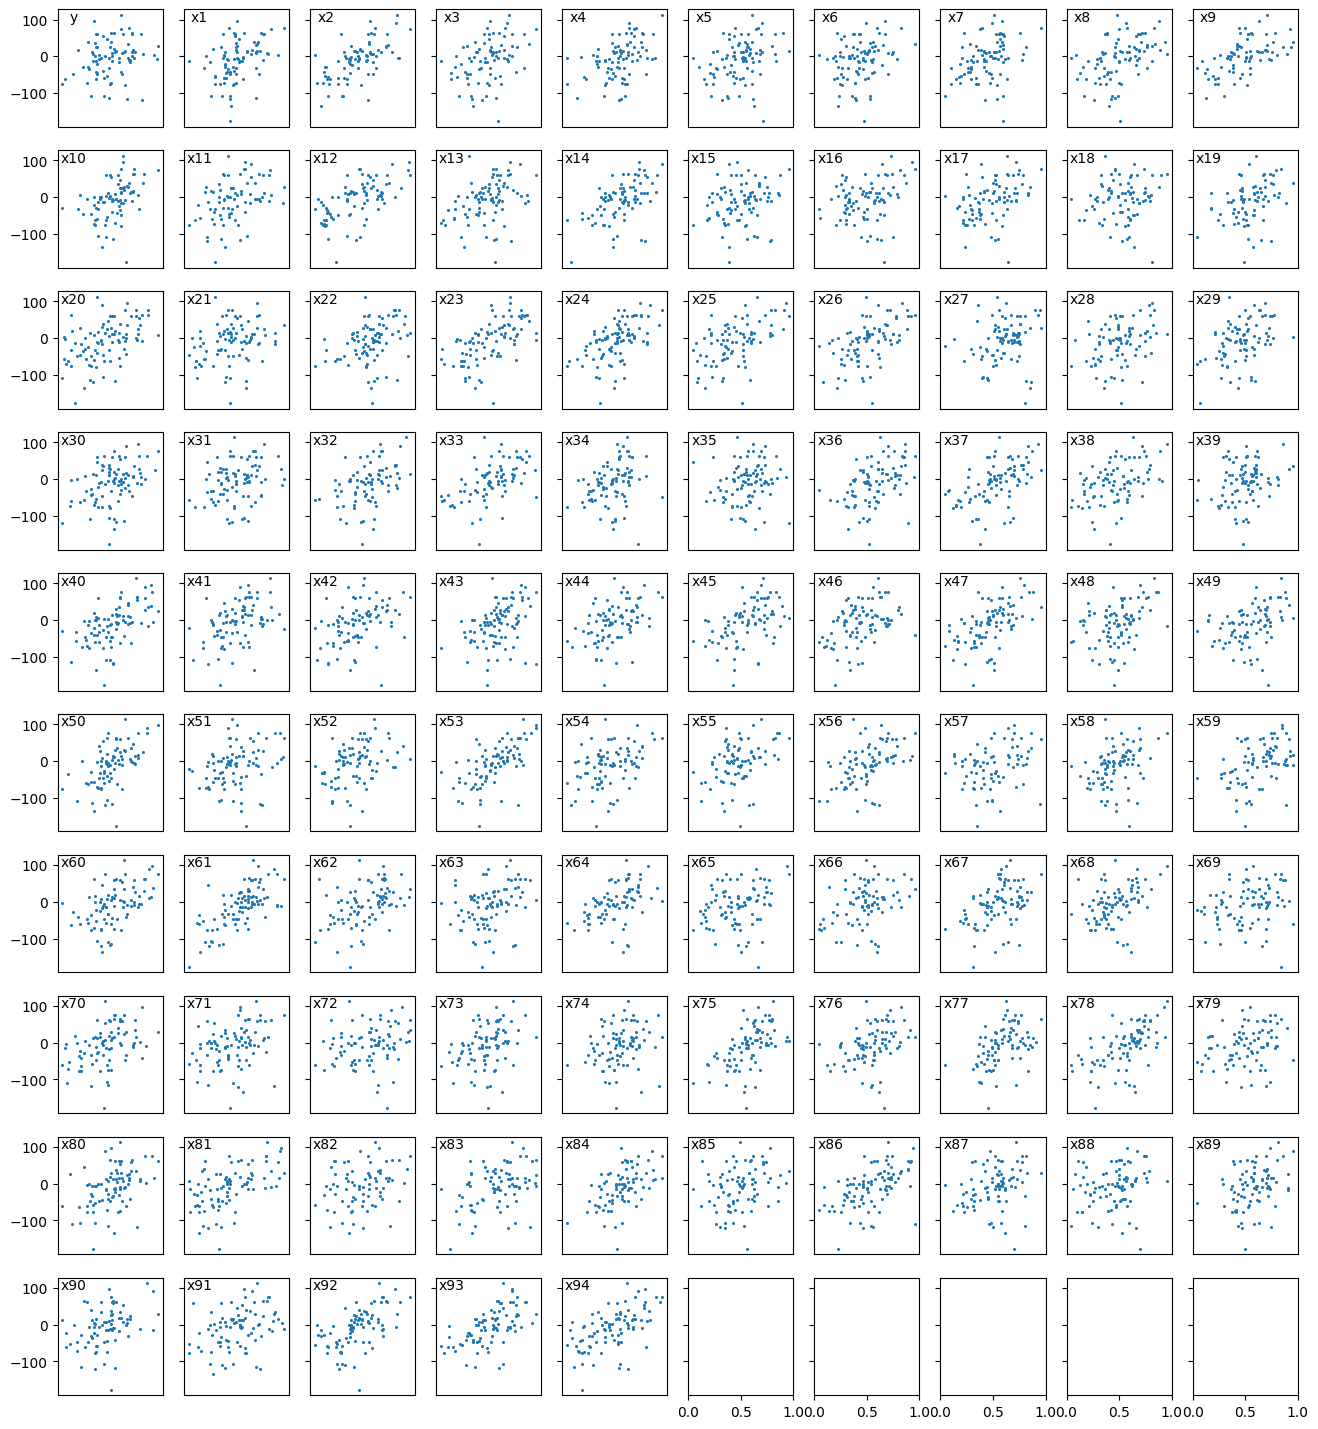

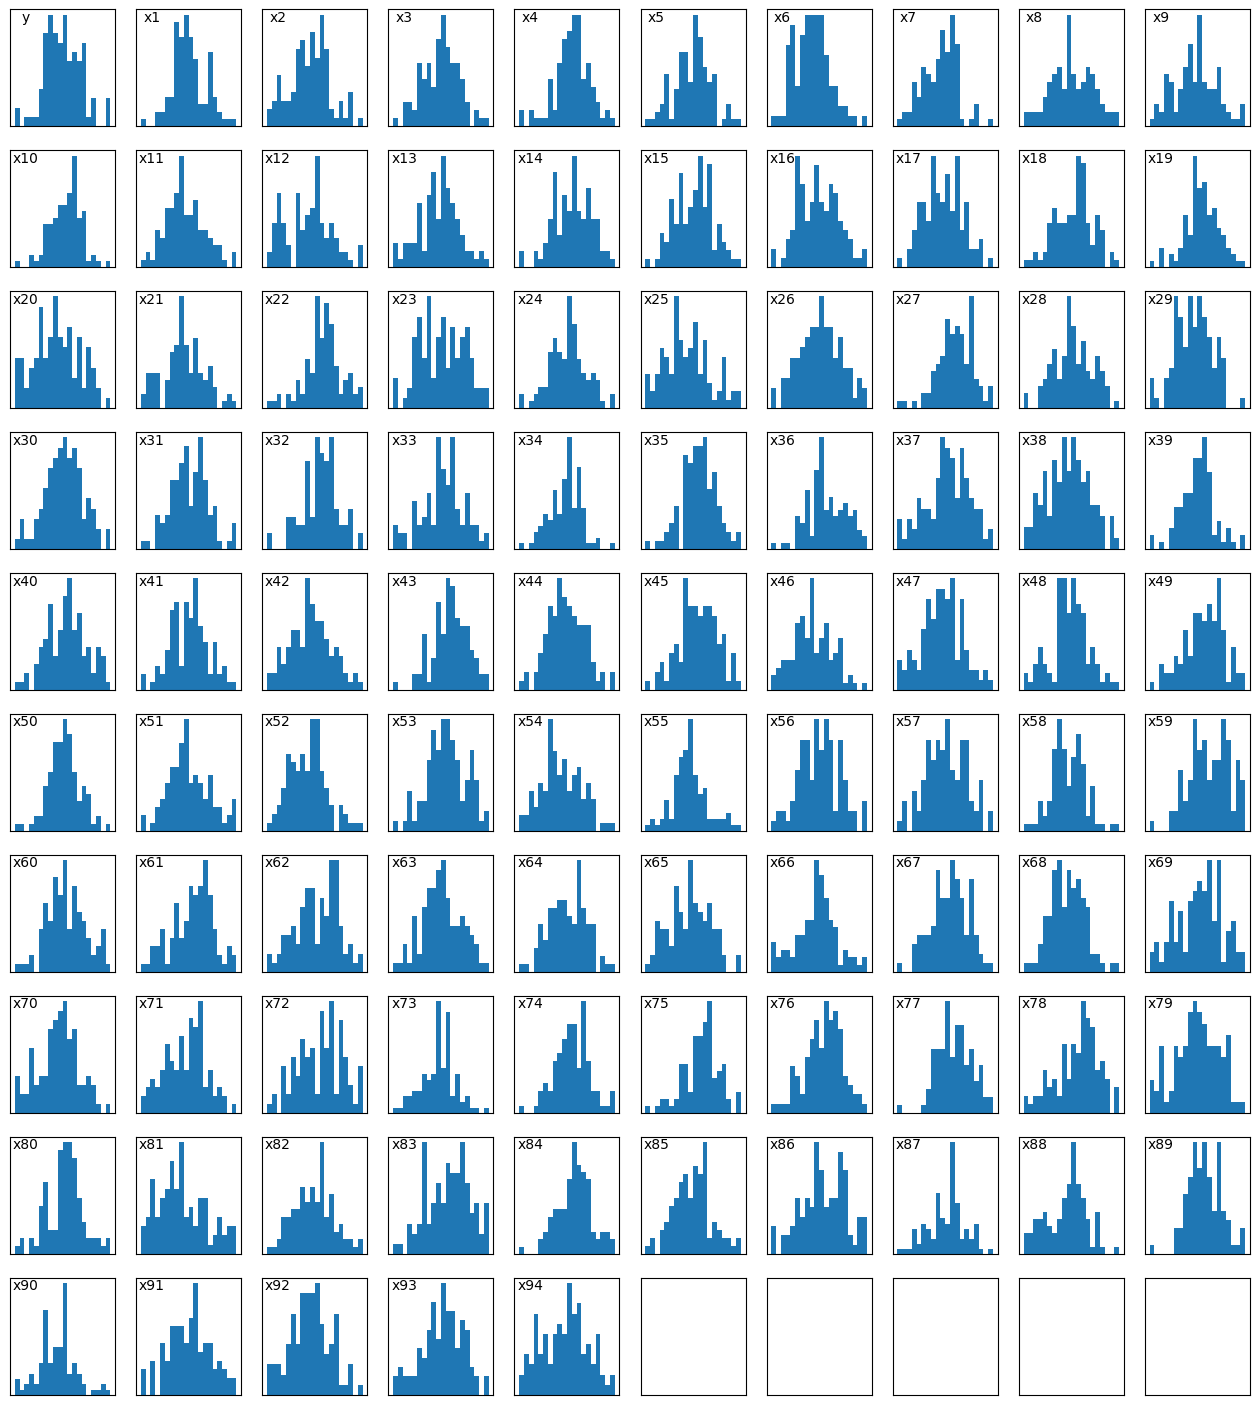

In [183]:
data = case1TrainSet()
data.KNN_imputation(5)
plotter = case1Plotter(data)
plotter.covariance_plot()
plotter.scatterplots()
plotter.scatterplots_imputed()
plotter.plotDataDistribution()


